<figure>
<img src="../Imagenes/logo-final-ap.png"  width="80" height="80" align="left"/> 
</figure>

# <span style="color:blue"><left>Aprendizaje Profundo</left></span>

# <span style="color:red"><center>Pronóstico de Series de Tiempo en Tensorflow</center></span>

## <span style="color:blue">Escritor</span>

- Oleg Jarma, Estadístico, ojarmam@unal.edu.co

## <span style="color:blue">Profesores</span>

### Coordinador

- Campo Elías Pardo, PhD, cepardot@unal.edu.co

### Conferencistas

- Alvaro  Montenegro, PhD, ammontenegrod@unal.edu.co
- Daniel  Montenegro, Msc, dextronomo@gmail.com 

##   <span style="color:blue">Asesora Medios y Marketing digital</span>
 

- Maria del Pilar Montenegro, pmontenegro88@gmail.com 

## <span style="color:blue">Asistentes</span>

- Nayibe Yesenia Arias, naariasc@unal.edu.co
- Venus Celeste Puertas, vpuertasg@unal.edu.co 

## <span style="color:blue">Contenido</span> 

* [Introducción](#Introducción)
* [Paquetes a utilizar](#Paquetes-a-utilizar)
* [Acciones de la empresa Apple](#Acciones-de-la-empresa-Apple)
  - [Preparación de los datos para el entrenamiento de la red LSTM](#Preparación-de-los-datos-para-el-entrenamiento-de-la-red-LSTM)
  - [Crea datos de entrenamiento](#Crea-datos-de-entrenamiento)
  - [Crea el modelo LSTM](#Crea-el-modelo-LSTM)
  - [Compila](#Compila)
  - [Entrena el modelo](#Entrena-el-modelo)
  - [Predicciones](#Predicciones)
  - [Caso multipaso](#Caso-multipaso)
* [Base de Datos "Weather"](#Base-de-Datos-"Weather")
  - [Modelo a un paso](#Modelo-a-un-paso)
    - [Modelo lineal](#Modelo-lineal)
    - [Denso Multi paso](#Denso-Multi-paso)
    - [Red Recurrente](#Red-Recurrente)
    - [Modelos multivariados](#Modelos-multivariados)
  - [Modelo multi paso](#Modelo-multi-paso)
    - [Modelos Single shot](#Modelos-Single-shot)
    - [Lineal](#Lineal)
    - [Densa](#Densa)
    - [RNN](#RNN)






    


  


## <span style="color:blue">Introducción</span> 

Basado en este [tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series#advanced_autoregressive_model)

Observaremos cómo utilizar redes neuronales para hacer pronósticos de series de tiempo. Se utilizarán Redes Recurrentes y Redes Convolucionales.

En esta guía veremos:
- Pronóstico a un paso
    - Una característica
    - Varias características
- Pronóstico de muchos pasos
    - Todos los pronósticos a la vez
    - Modelo autorregresivo

## <span style="color:blue">Paquetes a utilizar</span> 

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### <span style="color:red">Acciones de la empresa Apple</span>

Estos datos corresponden a la empresa *Apple*. Son  3019 datos que corresponden a observaciones del precio de la acción, el número de transacciones de la acción (compra-venta). Los datos son diarios (dias hábiles o comerciales). Están entre el 3 de enero de 2006 hasta el 1 de enero de 2018.

la columna *Date* es la fecha, *Open* es el valor de acción a la apertura del mercado, *High* el valor más alto alcanzado en el día, *Low* el valor más bajo del día, *Close* el valor al cierre,  *Volume* es el volúmenes de acciones transadas en el día  y *Name* es el código de identificación de la empresa, Apple en este caso.


Los datos puede ser bajados directamente de [Kaggle](https://www.kaggle.com/szrlee/stock-time-series-20050101-to-20171231)

In [2]:
#leemos el archivo de manera local

df = pd.read_csv('../Datos/AAPL_2006-01-01_to_2018-01-01.csv')


In [3]:
# Observamos los primeros datos
print('\n Shape of the data:')
print(df.shape)
df.head()


 Shape of the data:
(3019, 7)


,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
1,2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2,2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
3,2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
4,2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


Vamos a cambiar el índice de los datos. Tomaremos la fecha como indice: *df.index*. Los datos se reordenan para invertir la tabla, debido a que los datos contienen las observaciones más recientes en la parte superior de la tabla.

In [4]:
#creating dataframe with date and the target variable

df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']
# df = df.sort_index(ascending=True, axis=0)
data = pd.DataFrame(df[['Date', 'Close']])
#
#setting index
data.index = data.Date
data.drop('Date', axis=1, inplace=True)
data.head()

,Close
Date,
2006-01-03,10.68
2006-01-04,10.71
2006-01-05,10.63
2006-01-06,10.90
2006-01-09,10.86


Visualizamos los datos y definimos el conjunto de entrenamiento y el conjunto de validación

In [5]:
# plot
len_data = len(data)# 100%  = 3019
len_train = int(len_data*0.8) # 80%  = 2415
len_test = len_data- len_train # 20% = 604
print (len_data, '=', len_train, '+',len_test)

3019 = 2415 + 604


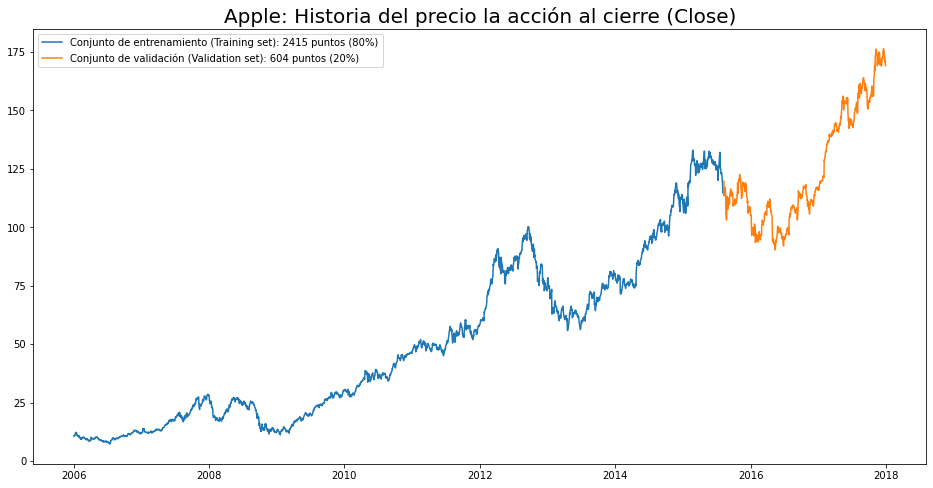

In [6]:
plt.figure(figsize=(16,8))
plt.plot(data[:len_train], label='Conjunto de entrenamiento (Training set): {} puntos (80%)'.format(len_train))
plt.plot(data['Close'][len_train:], label='Conjunto de prueba (test set): {} puntos (20%)'.format(len_test)) #248 data
plt.title("Apple: Historia del precio la acción al cierre (Close)", size = 20)
plt.legend()
plt.show()

## <span style="color:blue">Preparación de los datos para el entrenamiento de la red LSTM</span>

Para evitar problemas con las tendencias y para mejorar la estimación (entrenamiento) los datos se van a transformar a la escala $[0,1]$. Para las predicciones se utiliza la transformación inversa.

Primero extrae los valores y se crea el  objeto MinMaxScaler

In [7]:
# llamamos la función en específico
from sklearn.preprocessing import MinMaxScaler

dataset = data.values #to_numpy()


# creamos el escalador para estandarizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = np.squeeze(np.array(scaler.fit_transform(dataset)),axis=1) 


## <span style="color:blue">Crea datos de entrenamiento</span>

 La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 1 dato (la predicción a
 partir de esos "time_step" datos se hace para los siguentes días). Se conformará de esta forma el set de entrenamiento

1. Número de datos consecutivos para entrenamiento: time_step = 60. 
2. Días a predecir: days = 1

### <span style="color:blue">Función para crear los datos entrenamiento</span>

In [8]:
def multipaso_data(dataset, target, start_index, end_index, history_size,
                      target_size,  single_step=False):
    ''' dataset: conjunto de datos para las secuencias de entrada
        target:  conjunto de datos para las secuencias de salida
        start_index: índice inicial de donde empezar a tomar los datos
        end_index: índice final para tomar los datos. None para tomarlos todos
        history_size: tamaño de la venytana para crear las secuencias
        target_size: dentro de cuántas observaciones futuras desea pronosticar
        single_step: Predecir solamente un valor futuro (=True),
                     o predecir todos los valores hasta target_size(=False)
    '''  
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

Se coloca una semilla para gerantizar reproductibidad

In [9]:
tf.random.set_seed(100)

In [10]:
#
# hiperparámetros para crear las secuencias
#
# tamaño de pasos a futuro
future_target = 1

# tamaño secuencias de entrada
past_history = 60 

TRAIN_SPLIT = int(len_data*0.8) #2415: nuḿer0 de datos entreno

# Crea los datos
X_train, y_train = multipaso_data(dataset, dataset, 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, single_step=True)
X_test, y_test = multipaso_data(dataset, dataset, TRAIN_SPLIT,
                                                 None, past_history,
                                                 future_target, single_step=True)

print(TRAIN_SPLIT)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

2415
(2355, 60)
(2355,)
(543, 60)
(543,)


## <span style="color:blue">Crea el modelo LSTM</span>

In [11]:
# unidades de salida de las capas LSTM
#
units = 64
#
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1],1), name="LSTM_1"),
    tf.keras.layers.LSTM(units=units, name="LSTM_2"),
    tf.keras.layers.Dense(future_target, name="Output")])

model.summary()


2022-03-10 20:45:44.815012: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-10 20:45:44.866568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-10 20:45:44.866847: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-10 20:45:44.867481: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


## <span style="color:blue">Compila</span>

Se usará el optimizador Adam y la función de pérdida MSE

In [12]:
model.compile(loss='mse', optimizer='adam')


## <span style="color:blue"> Entrena el modelo</span>


In [22]:
history = model.fit(X_train,y_train,
                    epochs=20,
                    validation_split=0.1,
                    verbose=1,
                    batch_size=32)

Epoch 1/20
67/67 [==============================] - 4s 21ms/step - loss: 0.0055 - val_loss: 0.0011
Epoch 2/20
67/67 [==============================] - 0s 7ms/step - loss: 3.7474e-04 - val_loss: 0.0013
Epoch 3/20
67/67 [==============================] - 1s 8ms/step - loss: 3.8046e-04 - val_loss: 0.0037
Epoch 4/20
67/67 [==============================] - 1s 9ms/step - loss: 3.2330e-04 - val_loss: 0.0010
Epoch 5/20
67/67 [==============================] - 1s 8ms/step - loss: 3.2600e-04 - val_loss: 0.0031
Epoch 6/20
67/67 [==============================] - 1s 8ms/step - loss: 3.1790e-04 - val_loss: 0.0041
Epoch 7/20
67/67 [==============================] - 0s 7ms/step - loss: 3.2076e-04 - val_loss: 0.0019
Epoch 8/20
67/67 [==============================] - 1s 8ms/step - loss: 2.7540e-04 - val_loss: 0.0023
Epoch 9/20
67/67 [==============================] - 0s 7ms/step - loss: 2.7933e-04 - val_loss: 0.0019
Epoch 10/20
67/67 [==============================] - 0s 7ms/step - loss: 2.9928e-04 -

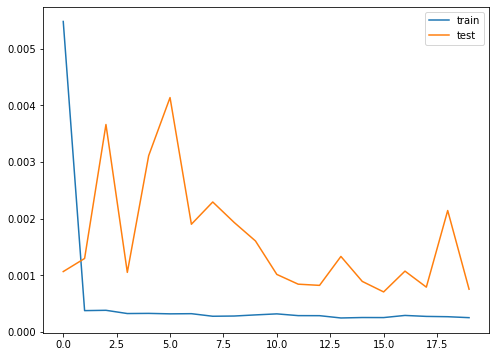

In [23]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

## <span style="color:blue">Predicciones</span>

In [24]:
# predictions
prediction = model.predict(X_test)
# prediction = scaler.inverse_transform(prediction)

### <span style="color:blue">Función para graficar predicciones</span>

In [16]:
def plot_prediction(real, prediccion):
    plt.plot(real,color='red', label='Valor real de la acción')
    plt.plot(prediccion, color='blue', label='Predicción de la acción')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()

#

In [25]:
pred =0
X_test_p = X_test[pred,:]
y_test_p = y_test[pred,:]
pred_p = prediction[pred,:]

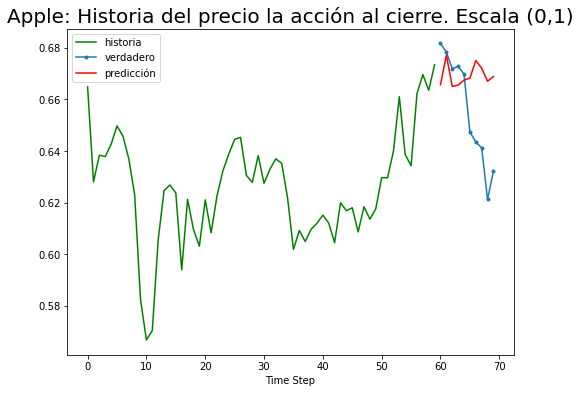

In [26]:
plt.plot(np.arange(0, len(X_test_p)), X_test_p, 'g', label="historia")
plt.plot(np.arange(len(X_test_p), len(X_test_p) + len(y_test_p)), y_test_p, marker='.', label="verdadero")
plt.plot(np.arange(len(X_test_p), len(X_test_p) + len(y_test_p)), pred_p, 'r', label="predicción")
#plt.ylabel('Valor')
plt.xlabel('Time Step')
plt.title("Apple: Historia del precio la acción al cierre. Escala (0,1)", size = 20)
plt.legend()
plt.show();


## <span style="color:blue">Caso multipaso</span>

Se crean ahora nuevas versiones de datos cuyos labels son una serie de datos completo. De esa forma se hará una predicción en más días a futuro

Repetimos el proceso completo con algunos cambios

In [19]:
#
# hiperparámetros para crear las secuencias
#
# tamaño de pasos a futuro
future_target = 10

# tamaño secuencias de entrada
past_history = 60 

TRAIN_SPLIT = int(len_data*0.8) #2415: nuḿer0 de datos entreno

# Crea los datos
X_train, y_train = multipaso_data(dataset, dataset, 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target)
X_test, y_test = multipaso_data(dataset, dataset, TRAIN_SPLIT,
                                                 None, past_history,
                                                 future_target)

print(TRAIN_SPLIT)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

2415
(2355, 60)
(2355, 10)
(534, 60)
(534, 10)


In [20]:
# unidades de salida de las capas LSTM
#
units = 64
#
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1],1), name="LSTM_1"),
    
    tf.keras.layers.LSTM(units=units, name="LSTM_2"),
    
    tf.keras.layers.Dense(future_target, name="Output")
])

#tf.keras.layers.Dropout()

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, 60, 64)            16896     
                                                                 
 LSTM_2 (LSTM)               (None, 64)                33024     
                                                                 
 Output (Dense)              (None, 10)                650       
                                                                 
Total params: 50,570
Trainable params: 50,570
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(loss='mse', optimizer='adam')


In [22]:
history = model.fit(X_train,y_train,
                    epochs=20,
                    validation_split=0.1,
                    verbose=1,
                    batch_size=32)

Epoch 1/20
67/67 [==============================] - 4s 21ms/step - loss: 0.0055 - val_loss: 0.0011
Epoch 2/20
67/67 [==============================] - 0s 7ms/step - loss: 3.7474e-04 - val_loss: 0.0013
Epoch 3/20
67/67 [==============================] - 1s 8ms/step - loss: 3.8046e-04 - val_loss: 0.0037
Epoch 4/20
67/67 [==============================] - 1s 9ms/step - loss: 3.2330e-04 - val_loss: 0.0010
Epoch 5/20
67/67 [==============================] - 1s 8ms/step - loss: 3.2600e-04 - val_loss: 0.0031
Epoch 6/20
67/67 [==============================] - 1s 8ms/step - loss: 3.1790e-04 - val_loss: 0.0041
Epoch 7/20
67/67 [==============================] - 0s 7ms/step - loss: 3.2076e-04 - val_loss: 0.0019
Epoch 8/20
67/67 [==============================] - 1s 8ms/step - loss: 2.7540e-04 - val_loss: 0.0023
Epoch 9/20
67/67 [==============================] - 0s 7ms/step - loss: 2.7933e-04 - val_loss: 0.0019
Epoch 10/20
67/67 [==============================] - 0s 7ms/step - loss: 2.9928e-04 -

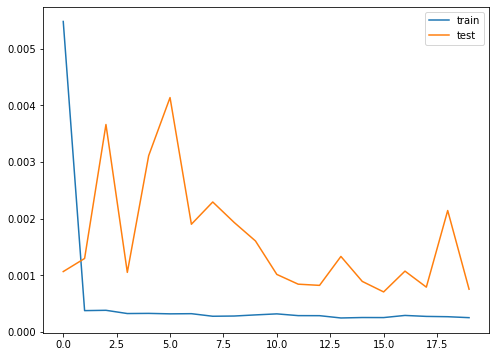

In [23]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [24]:
# predictions
prediction = model.predict(X_test)
# prediction = scaler.inverse_transform(prediction)

In [25]:
pred =0
X_test_p = X_test[pred,:]
y_test_p = y_test[pred,:]
pred_p = prediction[pred,:]

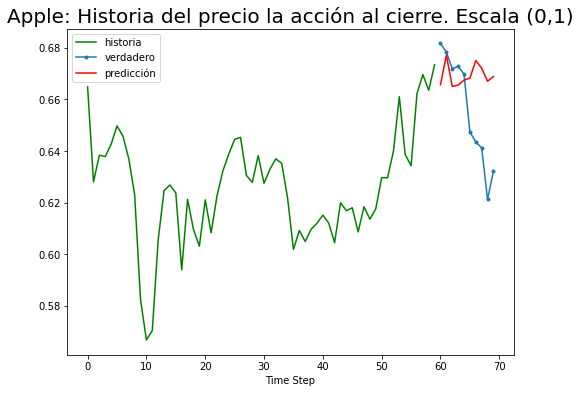

In [26]:
plt.plot(np.arange(0, len(X_test_p)), X_test_p, 'g', label="historia")
plt.plot(np.arange(len(X_test_p), len(X_test_p) + len(y_test_p)), y_test_p, marker='.', label="verdadero")
plt.plot(np.arange(len(X_test_p), len(X_test_p) + len(y_test_p)), pred_p, 'r', label="predicción")
#plt.ylabel('Valor')
plt.xlabel('Time Step')
plt.title("Apple: Historia del precio la acción al cierre. Escala (0,1)", size = 20)
plt.legend()
plt.show();


### <span style="color:red">Base de Datos "Weather"</span>

Se utiliza la base de datos de clima del [Instituto Max Planck de Biogeoquímica](https://www.bgc-jena.mpg.de/wetter/). Esta cuenta con 14 variables como temperatura del aire y presión atmosférica. Se trabajará con datos entre 2009 y 2016 recolectados cada 10 minutos

In [27]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    cache_dir='/media/storage', #dirección de extracción
    cache_subdir='Datasets', #carpeta que se crea para la extracción
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
print(csv_path)

/media/storage/Datasets/jena_climate_2009_2016.csv


Aquí sólo se tratará con las observaciones por hora, así que se hará un sub muestreo en el que se recogerá cada sexto dato.

También se podría hacer una agregación de los datos con la función `df.resample('H', origin='start').agg('mean')` si se quiere resumir el comportamiento dentro de la hora

In [28]:
df = pd.read_csv(csv_path)

df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Hacemos la gráfica de algunas variables para ver su comportamiento

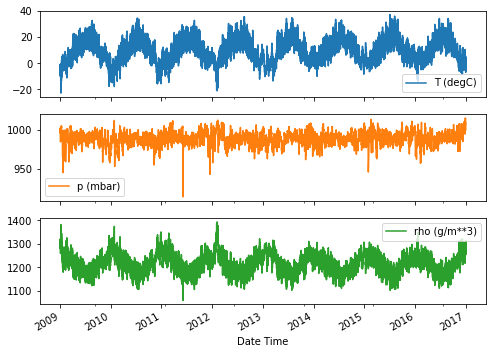

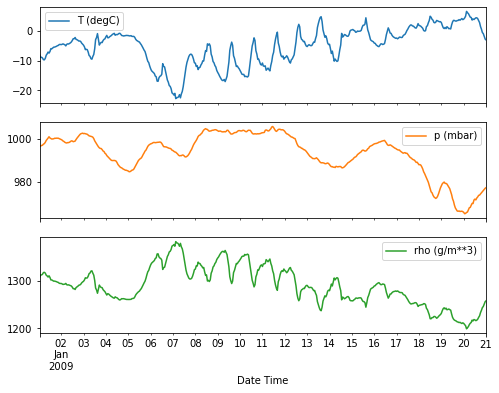

In [29]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### <span style="color:red">Pre procesamiento</span>

Por supuesto, para poder generar un modelo correctamente, es necesario entender los datos

In [30]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


¿Qué llama la atención? el mínimo de las variables de velocidad de viento es -9999, un valor probablemente erroneo que puede causar problemas como sesgo.
Además, como se tiene una variable de la dirección del viento, la velocidad siempre debe ser mayor o igual a cero. Arreglemos esto

In [31]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# revisamos si los cambios se muestran en el dataframe
df['wv (m/s)'].min()

0.0

Ahora nos adentramos en cosas más específicas con algunas variables......

#### Viento

La columna de dirección del viento está en ángulos, lo cual no es buena variable de entrada para un modelo.

Veamos cómo se ven los datos de viento

Text(0, 0.5, 'Wind Velocity [m/s]')

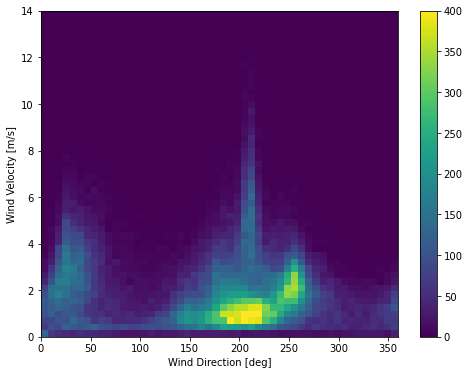

In [32]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

Las variables de dirección y velocidad del viento serán más sencillas de interpretar para el modelo si las convertimos en vectores

In [33]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convertir a radianes.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calcular los componentes bidimensionales del viento.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Se repite el proceso con el viento máximo.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

La distribución del viento ahora será más fácil de entender

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

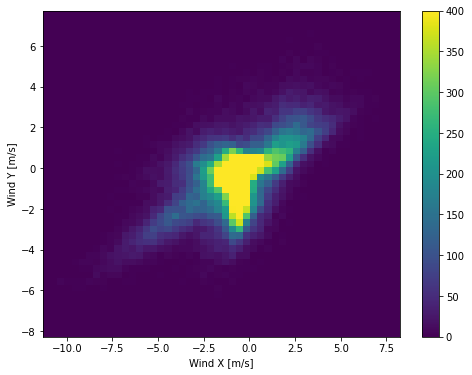

In [34]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### Tiempo

Además, la columna de tiempo nos brindará información importante, pero hay que convertirla a algo verdaderamente utilizable

In [35]:
print(date_time)

5        2009-01-01 01:00:00
11       2009-01-01 02:00:00
17       2009-01-01 03:00:00
23       2009-01-01 04:00:00
29       2009-01-01 05:00:00
                 ...        
420521   2016-12-31 19:10:00
420527   2016-12-31 20:10:00
420533   2016-12-31 21:10:00
420539   2016-12-31 22:10:00
420545   2016-12-31 23:10:00
Name: Date Time, Length: 70091, dtype: datetime64[ns]


Como estos son datos climáticos, se puede suponer que se tiene tanto periodicidad en el día como en el año, pero los datos en este formato no lo repesentan correctamente. Para aprovechar esta información, usaremos transformaciones de seno y coseno.

In [36]:
#Convertimos los datos a segundos ##PELIGRO, NO USAR ASÍ

timestamp_s = date_time.map(pd.Timestamp.timestamp)
#obtenemos el seno y coseno para obtener señales más claras

day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

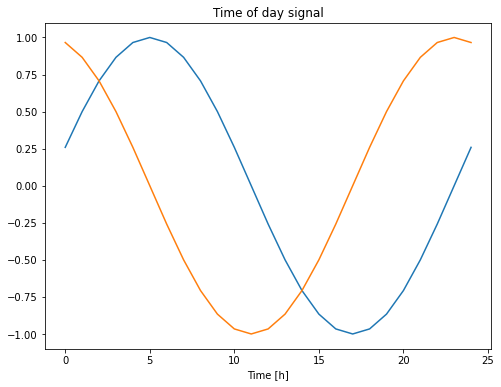

In [37]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

#### Separación de los datos

Haremos un clásico corte de los datos (70%, 20%, 10%) para entrenamiento, Validación y test. Que se note que no se está haciendo shuffle en este caso

In [38]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

#### Normalización de los datos

Práctica común para evitar sesgo en los datos. Aquí se hace manualmente

In [39]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Observemos las distribuciones de los datos

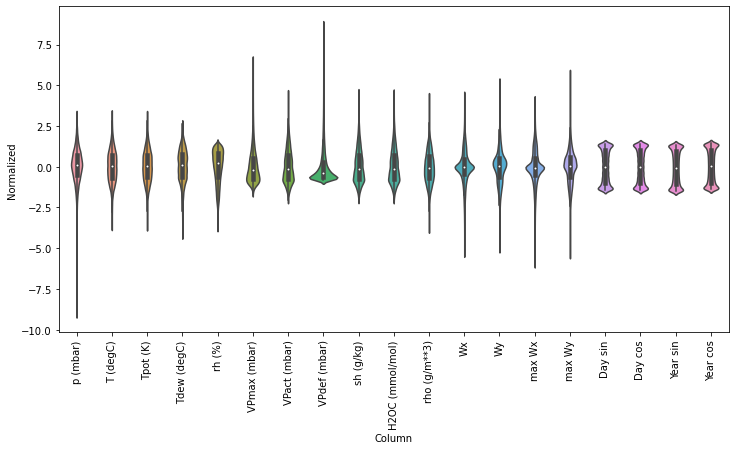

In [40]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

### <span style="color:red">Ventaneo de Datos</span>

Los modelos que usaremos tendrán como datos de entrada "ventanas" de datos consecutivos. Estas tienen las siguientes características:

- el numero de "pasos" de las ventanas de entrada y labels
- el "offset" entre los anteriores
- las variables que son usadas como entrada, labels o ambos.

Se van a construir distintas ventanas para modelos de salida univariada, salida multivariada, a un paso o multi paso.

Por ejemplo, definimos un modelo con ventanas de 24 horas en el pasado para predecir un paso a 24 en el futuro
<center>
<img src="https://www.tensorflow.org/tutorials/structured_data/images/raw_window_24h.png" 
     alt="ventaneo_24-24" width="500">
<center>

O un modelo que predice una hora en el futuro, dadas 6 horas de historia
<center>
<img src="https://www.tensorflow.org/tutorials/structured_data/images/raw_window_1h.png" 
     alt="ventaneo_6-1" width="500">
<center>

A continuación definiremos una clase llamada `windowGenerator` que sea capaz de:
- Manejar indices y offsets
- Hacer un ventaneo de pares `(variables, labels)`
- hacer gráficos de las ventanas
- Generar lotes de dichas ventanas para entrenamiento, validación y prueba

#### Índices y offsets

Comenzamos a generar la clase `WindowGenerator`. el método `__init__` define los indices de los datos de entrada y los labels

Luego toma los datos de entrenamiento, validación y prueba y los convierte en `tf.Data.Dataset`

In [41]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Guarda los datos en crudo
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Se trabajan las columnas de labels
        self.label_columns = label_columns
        if label_columns is not None:
          self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Definimos los parámetros de las ventanas
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    #Método para representar los objetos en forma de string

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

Creamos las ventanas de los ejemplos

In [42]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [43]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

#### Corte

Dada una lista de entradas consecutivas, el método `split_window` hará la conversión a ventanas de entradas y labels

<center>
<img src="https://www.tensorflow.org/tutorials/structured_data/images/split_window.png" 
     alt="ventaneo_6-1" width="500">
<center>

In [44]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # El corte no conserva la información sobre la forma, 
    # Por eso es mejor definir las formas para llenar correctamente los datasets
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

#Definimos la función recién hecha como método de WindowGenerator
WindowGenerator.split_window = split_window

In [45]:
# Apilamos tres cortes, la longitud total de la ventana
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


#### Gráficas

Agregamos un método para visualizar los cortes de las ventanas

In [46]:
w2.example = example_inputs, example_labels

In [47]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

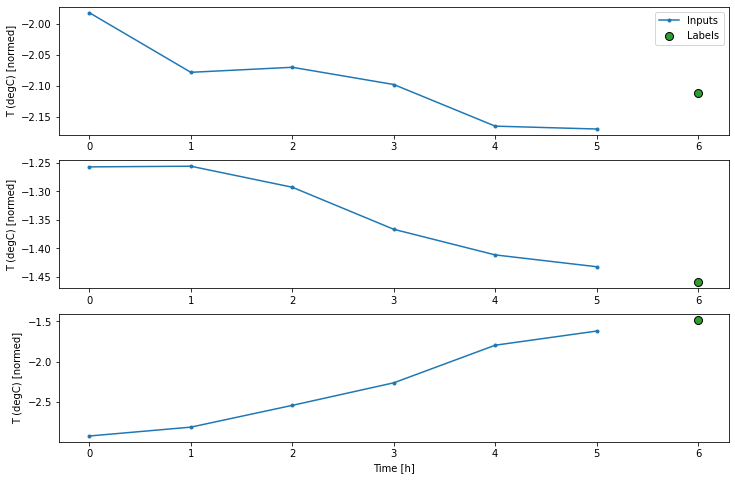

In [48]:
w2.plot()

#### Creación de Datasets

Finalmente, creamos un método que toma el Dataframe de series de tiempo y lo convierte en `tf.data.Dataset` como pares de forma `(input_window, label_window)`. esto se logra usando la función `preprocessing.timeseries_dataset_from_array`

In [49]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

Podemos agregar propiedades para poder acceder a los datos de entrenamiento, validación y prueba como Datasets de tensorflow, utilizando la función que acabamos de crear. Además agregamos un lote de ejemplo para gráficos rápidos

In [50]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Se toma y se guarda en el caché un lote de ejemplo de 'Entradas y labels' para gráficar"""
    result = getattr(self, '_example', None)
    if result is None:
        # No se encontró un lote, así que creamos uno del dataset '.train'
        result = next(iter(self.train))
        # se guarda en el caché para futuros usos
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Ahora tenemos acceso a los datasets como objetos de tensorflow!

E iterar sobre esos, genera lotes concretos

In [51]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [52]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


### <span style="color:red">Modelo a un paso</span>

Este es el modelo más sencillo de construir.Predecimos una única variable con una historia de un paso a un paso en el futuro.

Comenzaremos prediciendo la variable `T (degC)`

Configuramos `WindowGenerator` para que produzca pares a un paso con la varible a predecir

In [53]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

Generamos los tres datasets e iteramos sobre ellos

In [54]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


#### Base de referencia

Antes de armar el modelo, es buena idea tener una base de referencia para el rendimiendo con respecto a los modelos más complejos

Aquí haremos un modelo que hace una predicción en el futuro dado los datos actuales. El modelo retorna la temperatura actual y predice si hubo cambios o no.

In [55]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Instanciamos y evaluamos el modelo.

In [56]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 1s 2ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


Lastimosamente estas métricas no nos dicen mucho de cómo trabaja el modelo

Podemos graficar las métricas de este modelo, pero la verdad no hay mucho que observar con una sola muestra.

Razón por la cual creamos una ventana de 24 horas de entradas consecutivas y labels de una vez. Esto no cambia lo que hace el modelo. Estamos haciendo una predicción cada hora durante 24 horas

<center>
<img src="https://www.tensorflow.org/tutorials/structured_data/images/last_window.png" 
     alt="ventaneo_6-1" width="500">
<center>

In [57]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

In [58]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


Ahora si obtendremos gráficos más interesantes

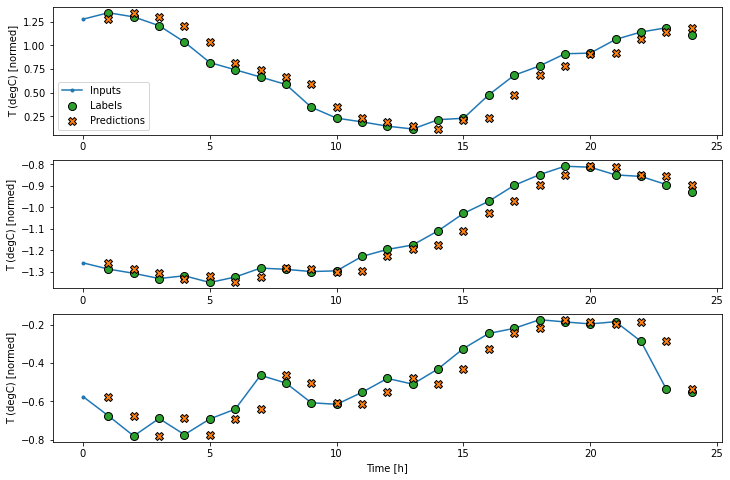

In [59]:
wide_window.plot(baseline)

#### Modelo Lineal

Aplicamos una transformación lineal entre la entrada y la salida.

Esto lo logramos con una capa densa sin función de activación

In [60]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [61]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


In [62]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [63]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 5s 3ms/step - loss: 0.1825 - mean_absolute_error: 0.2438 - val_loss: 0.0099 - val_mean_absolute_error: 0.0734
Epoch 2/20
1534/1534 [==============================] - 6s 4ms/step - loss: 0.0095 - mean_absolute_error: 0.0716 - val_loss: 0.0089 - val_mean_absolute_error: 0.0690
Epoch 3/20
1534/1534 [==============================] - 6s 4ms/step - loss: 0.0091 - mean_absolute_error: 0.0697 - val_loss: 0.0088 - val_mean_absolute_error: 0.0689
Epoch 4/20
1534/1534 [==============================] - 6s 4ms/step - loss: 0.0090 - mean_absolute_error: 0.0697 - val_loss: 0.0087 - val_mean_absolute_error: 0.0685
Epoch 5/20
1534/1534 [==============================] - 7s 4ms/step - loss: 0.0090 - mean_absolute_error: 0.0696 - val_loss: 0.0088 - val_mean_absolute_error: 0.0694
Epoch 6/20
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0090 - mean_absolute_error: 0.0696 - val_loss: 0.0086 - val_mean_absolute_error: 0.0680
Epo


Igual que el modelo anterior, este se puede aplicar en lotes de ventanas amplias, haciendo predicciones independientes de manera consecutiva.
<center>
<img src="https://www.tensorflow.org/tutorials/structured_data/images/wide_window.png" 
     alt="ventaneo_6-1" width="500">
</center>

In [64]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


Vamos a graficar las predicciones. ¿Se nota una mejora al modelo anterior?

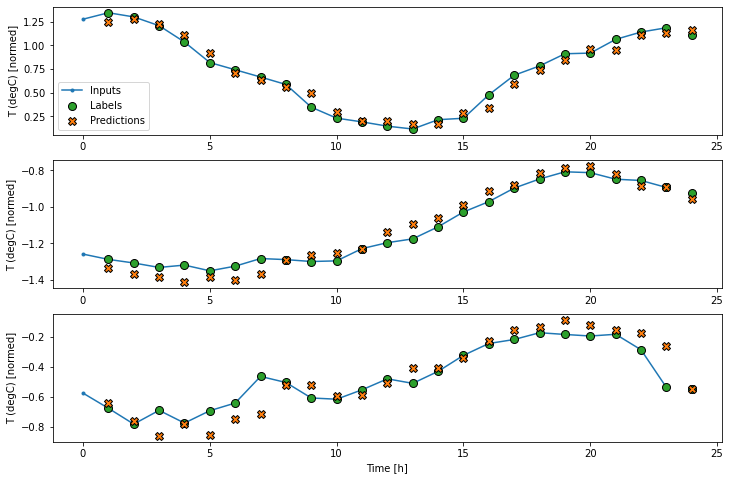

In [65]:
wide_window.plot(linear)

como es un modelo lineal, es sencillo de interpretar los pesos de este.

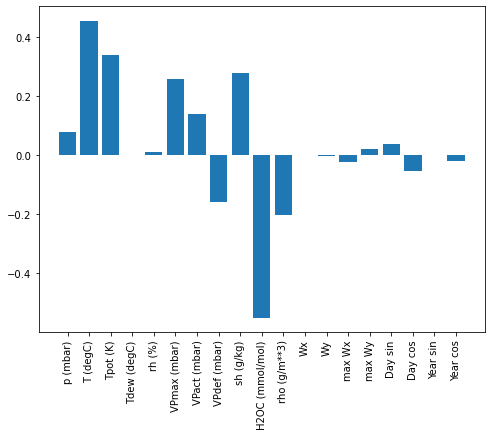

In [66]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

#### Denso Multi paso

El modelo a un paso no tiene contexto de los valores actuales, ni ve como estos cambian a través del tiempo. Para arreglar esto, usamos varios pasos de tiempo como entrada del modelo.

Los modelos anteriores tomaban cada paso de manera independiente. Aquí comenzará a tomar varios pasos como entrada para generar una sola salida

<center>
<img src="https://www.tensorflow.org/tutorials/structured_data/images/conv_window.png" 
     alt="ventaneo_6-1" width="300">
<center>

In [67]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

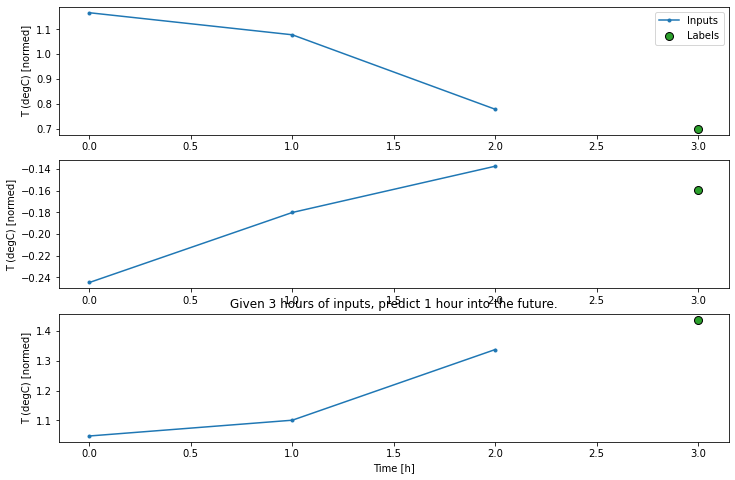

In [68]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

Logramos entrenar este modelo de multiple entrada agregando `tf.keras.layers.Flatten` como la primera capa

In [69]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [70]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [71]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 2s 4ms/step - loss: 0.0063 - mean_absolute_error: 0.0557


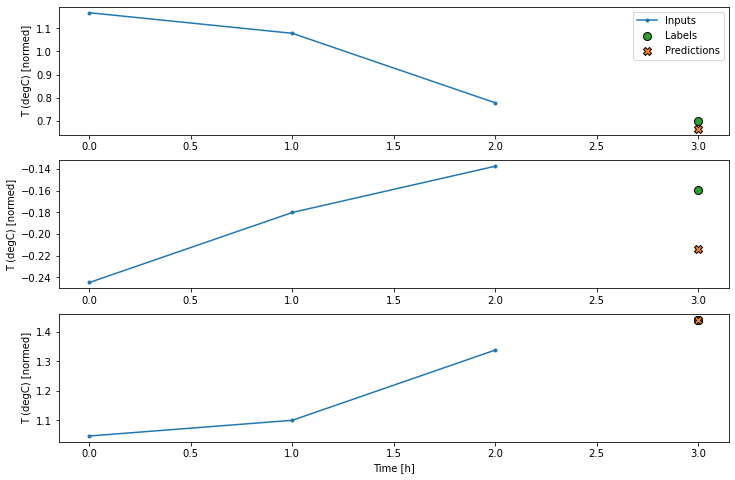

In [72]:
conv_window.plot(multi_step_dense)

### Red Recurrente

La preferente para datos secuenciales/Series de tiempo.

En este caso usaremos una capa `layers.LSTM`. Un parámetro importante de estas es el `return_sequences`, cuyo valor puede implicar dos cosas:

- Falso: la capa tiene de salida el último paso de tiempo. 

<center>
<img src="https://www.tensorflow.org/tutorials/structured_data/images/lstm_1_window.png" 
     alt="ventaneo_6-1" width="300">
</center>
    
- Verdadero: habrá una salida por cada dato de entrada. Esto es principalmente usado cuando se tienen varias capas recurrentes
<center>
<img src="https://www.tensorflow.org/tutorials/structured_data/images/lstm_many_window.png" 
     alt="ventaneo_6-1" width="300">
</center>

In [73]:
lstm_model = tf.keras.models.Sequential([
    # forma [lote, pasos, variables] => [lote, pasos, unidades_lstm]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # forma => [lote, pasos, features]
    tf.keras.layers.Dense(units=1)
])

Con el `return_sequences=True`, el modelo se puede hacer un entrenamiendo de 24 horas a la vez

In [74]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


In [75]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

 99/438 [=====>........................] - ETA: 1s - loss: 0.0056 - mean_absolute_error: 0.0511438/438 [==============================] - 2s 4ms/step - loss: 0.0056 - mean_absolute_error: 0.0510


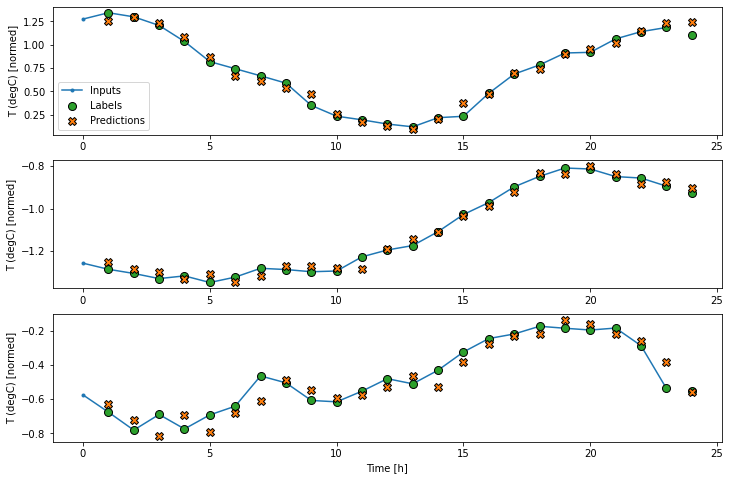

In [76]:
wide_window.plot(lstm_model)

#### Rendimiento

Vamos a ver cómo se diferencian los modelos 

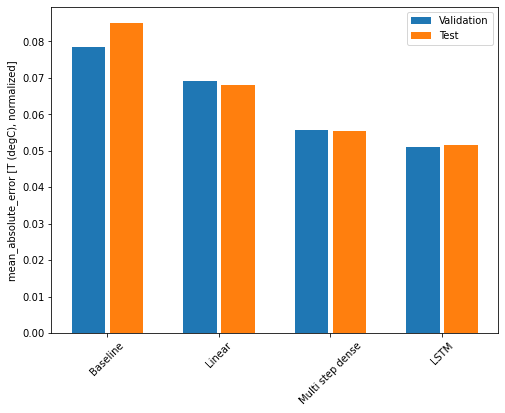

In [77]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [78]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0681
Multi step dense: 0.0554
LSTM        : 0.0516


#### Modelos multivariados

Hasta ahora sólo hemos lidiado con predicciones de una variable, pero esto facilmente se puede extender a casos multivariados. Esto se hace cambiando la ventana de labels a la cantidad que buscamos

Observemos cómo se comporta la red recurrente con predicciones multivariadas

In [79]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

print(wide_window)

lstm_model = tf.keras.models.Sequential([
    # forma [lote, pasos, variables] => [lotes, pasos, unidades_lstm]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # forma => [lote, pasos, variables]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

 23/438 [>.............................] - ETA: 0s - loss: 0.0611 - mean_absolute_error: 0.1197 438/438 [==============================] - 2s 4ms/step - loss: 0.0617 - mean_absolute_error: 0.1203

CPU times: user 4min 31s, sys: 55.9 s, total: 5min 27s
Wall time: 2min 15s


Vemos que el valor "MAE" en el caso multivariado es mayor al del caso univariado. ¿cuál es la razón de esto?

### <span style="color:red">Modelo multi paso</span>

A pesar de hacer predicciones en grandes ventanas de tiempo, los modelos anteriores siguen haciendo predicciones a una hora en el futuro. Aquí, los modelos comenzaran a predecir múltiples pasos en el futuro, generando una franja completa de tiempo

Primero, generamos ventanas con 24 horas de historia para predecir 24 horas en el futuro

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

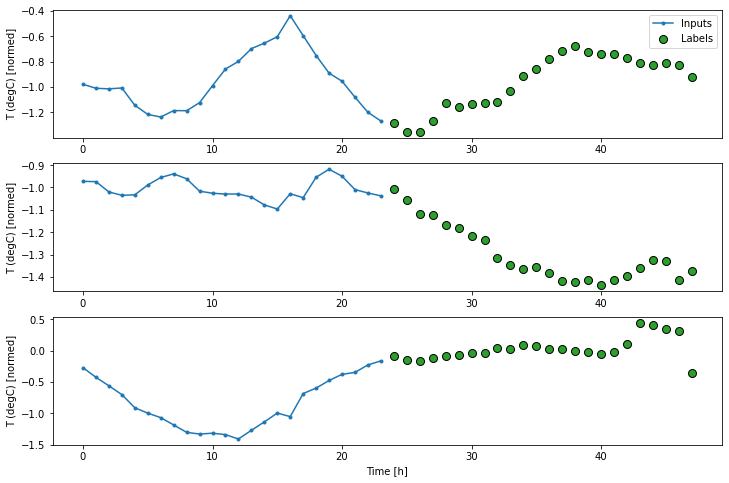

In [80]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

#### Base de referencia

Haremos un modelo de referencia que simplemente repita el último paso de entrada para cada ventana de salida

437/437 [==============================] - 1s 2ms/step - loss: 0.6285 - mean_absolute_error: 0.5007


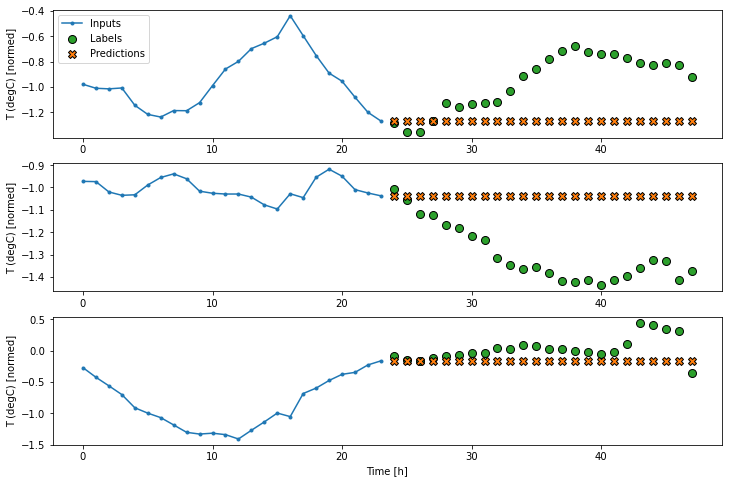

In [81]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Otro punto de referencia es repetir el dato de entrada en las siguientes 24 horas, haceindo la suposición de que el comportamiento va a ser similar en la misma hora

437/437 [==============================] - 1s 2ms/step - loss: 0.4270 - mean_absolute_error: 0.3959


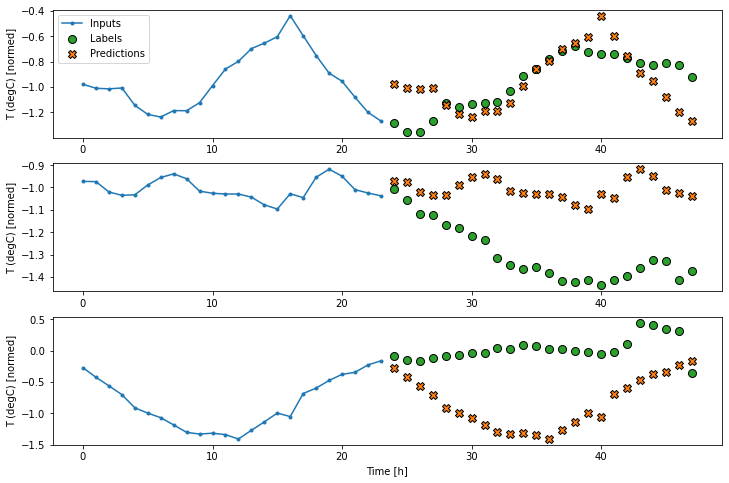

In [82]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

#### Modelos Single shot

Lo que se va a hacer en este modelo es predecir la secuencia entera de tiempo en un solo paso o en un solo "tiro". Esto se logra, por ejemplo definiendo las unidades de salida de una capa densa como `PASOS_SALIDA*variables`, después se cambia la forma de las salidas para que el resultado sea como una matriz



<center>
<img src="https://c.tenor.com/u2LD0oM-x30AAAAC/simpsons-makeup.gif" 
     alt="ventaneo_6-1" width="300">
<figcaption>Piénsenlo como una escopeta</figcaption>
</center>


Vamos a revisar los modelos anteriores y los pasaremos a multi paso

#### Lineal

Este modelo tendrá poca potencia ya que necesita predecir varios puntos a futuro a partir de uno de entrada

<center>
<img src="https://www.tensorflow.org/tutorials/structured_data/images/multistep_dense.png" 
     alt="ventaneo_6-1" width="300">
</center>

437/437 [==============================] - 1s 3ms/step - loss: 0.2552 - mean_absolute_error: 0.3048


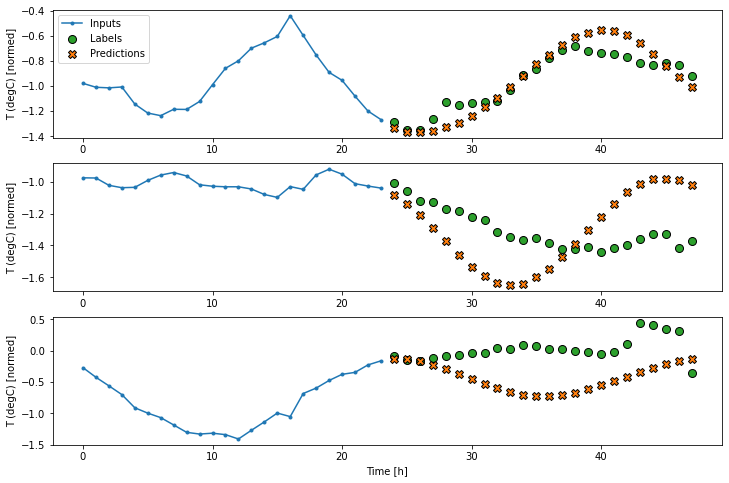

In [83]:
multi_linear_model = tf.keras.Sequential([
    # Toma el último paso de tiempo
    # forma [lote, tiempo, variables] => [lotes, 1, variables]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # forma => [lotes, 1, pasos_salida*variables]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # forma => [lote, pasos_salida, variables]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Densa

Agregando una capa densa le dará más poder a la red, pero sigue solo prediciendo a partir de un paso

437/437 [==============================] - 1s 3ms/step - loss: 0.2226 - mean_absolute_error: 0.2827


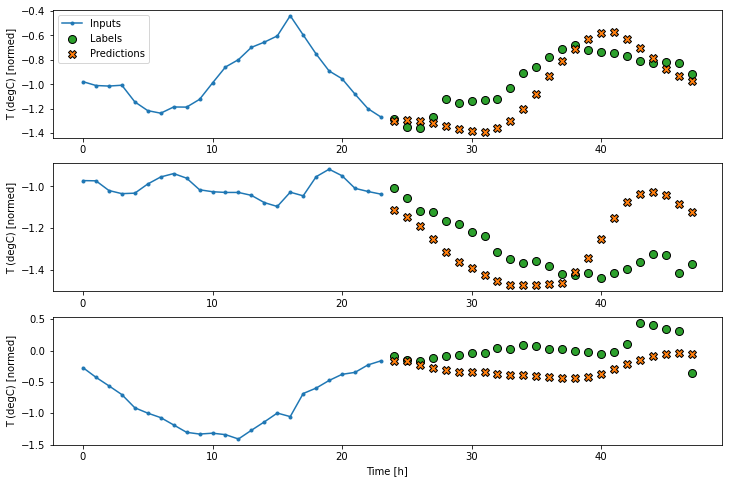

In [84]:
multi_dense_model = tf.keras.Sequential([
    # Toma el último paso de tiempo
    # forma [lote, tiempo, variables] => [lote, 1, variables]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # forma => [lote, 1, unidades_densas]
    tf.keras.layers.Dense(512, activation='relu'),
    # forma => [lote, pasos_salida*variables]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # forma => [lote, pasos_salida, variables]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### RNN

El modelo recurrente es capaz de usar la ventana completa de entradas para la predicción. Se guardará el estado de las últimas 24 horas antes de predecir las siguientes 24 horas.

En este formato "single-shot" solo se produce la salida en el último paso de tiempo, así que definimos `return_sequence=False` en la capa LSTM

<center>
<img src="https://www.tensorflow.org/tutorials/structured_data/images/multistep_lstm.png" 
     alt="ventaneo_6-1" width="300">
</center>

437/437 [==============================] - 1s 3ms/step - loss: 0.2142 - mean_absolute_error: 0.2843


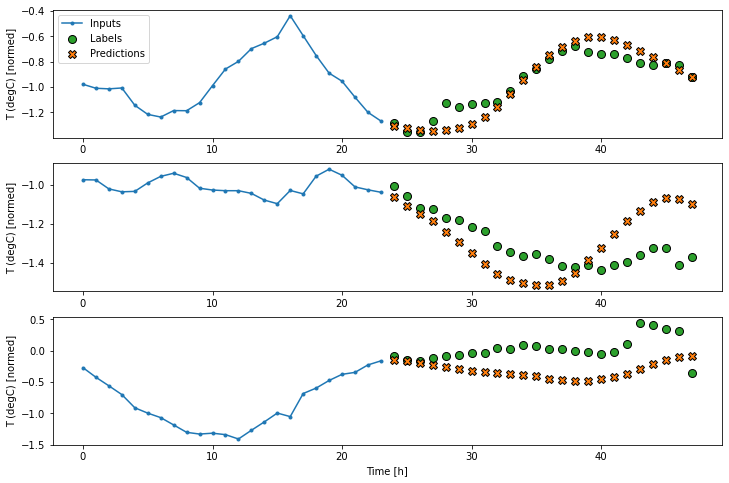

In [85]:
multi_lstm_model = tf.keras.Sequential([
    # forma [lote, tiempo, variables] => [lote, unidades_lstm].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Forma => [lote, pasos_salida*variables].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # forma => [lote, pasos_salida, variables].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

#### Rendimiento

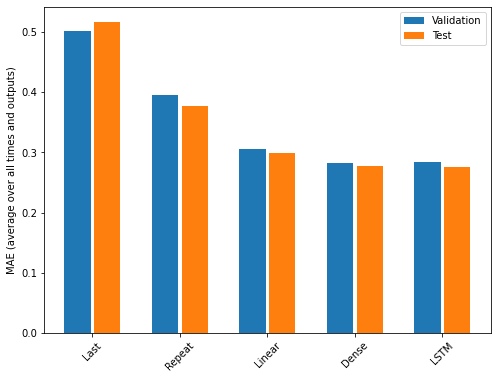

In [86]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [87]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5157
Repeat  : 0.3774
Linear  : 0.2983
Dense   : 0.2775
LSTM    : 0.2761


¿Vale la pena el esfuerzo por el modelo más complejo?